# Advanced integration tutorial

In this tutorial, we explore the integration of two multi-sample datasets using the `harmonypy` and `scanorama` libraries. The first dataset originates from a colorectal cancer study, comprising 12 tissue sections distributed across two biological replicates for each of the six samples. The details of this dataset are documented in [Valdeolivas et al. 2023](https://www.biorxiv.org/content/10.1101/2023.01.23.525135v2). The second dataset featured in this tutorial is derived from a mouse renal ischemia study, encompassing five samples collected at various time points, as outlined by [Eryn E. et al. 2022](https://doi.org/10.1681/ASN.2021081150).

In [1]:
import scanorama
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import chrysalis as ch

## 1. Colorectal Cancer

For this tutorial we are working with `h5ad` files that can be downloaded using this [link](https://drive.google.com/file/d/1Pt1imP4wAyoI1qzT6jDNyvlamWN_8vdd/view?usp=drive_link).

In [2]:
data_dir = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/crc_samples'

### 1.1 Preprocess samples

We start by reading the samples, performing QC and normalization, detecting spatially variable genes, and then saving the processed samples.

In [4]:
samples = glob(data_dir + '/*.h5ad')

for sample in samples:

    ad = sc.read_h5ad(sample)

    # replace .uns dictionary key with the `sample_id` column to make it easier reach the H&E images
    spatial_key = list(ad.uns['spatial'].keys())[0]
    ad.uns['spatial'][ad.obs['sample_id'][0]] = ad.uns['spatial'][spatial_key]
    del ad.uns['spatial'][spatial_key]

    # we can optionally use ENSEMBL gene IDs instead of gene symbols to deal with non-unique gene identifiers
    # this circumvents issues during integration
    ad.var['gene_symbols'] = ad.var_names
    ad.var_names = ad.var['gene_ids']

    assert len(np.unique(ad.var_names)) == len(ad.var)

    # ad.var_names_make_unique()

    # filter low quality spots
    sc.pp.calculate_qc_metrics(ad, inplace=True)
    sc.pp.filter_genes(ad, min_cells=10)
    sc.pp.filter_cells(ad, min_counts=2000)
    sc.pp.filter_cells(ad, min_genes=10)

    # normalize counts
    sc.pp.normalize_total(ad, inplace=True, target_sum=1e4, exclude_highly_expressed=True)
    sc.pp.log1p(ad)

    # detect spatially variable genes
    ch.detect_svgs(ad, min_morans=0.05, min_spots=0.05)

    # save samples
    ad.write_h5ad(data_dir + f'/ch_{ad.obs["sample_id"][0]}.h5ad')

Calculating SVGs:  52%|█████▏    | 6424/12285 [00:39<00:35, 163.01it/s]


KeyboardInterrupt: 

### 1.2 Create an integrated AnnData object

Next we read back the saved samples and take a look at the H&E.

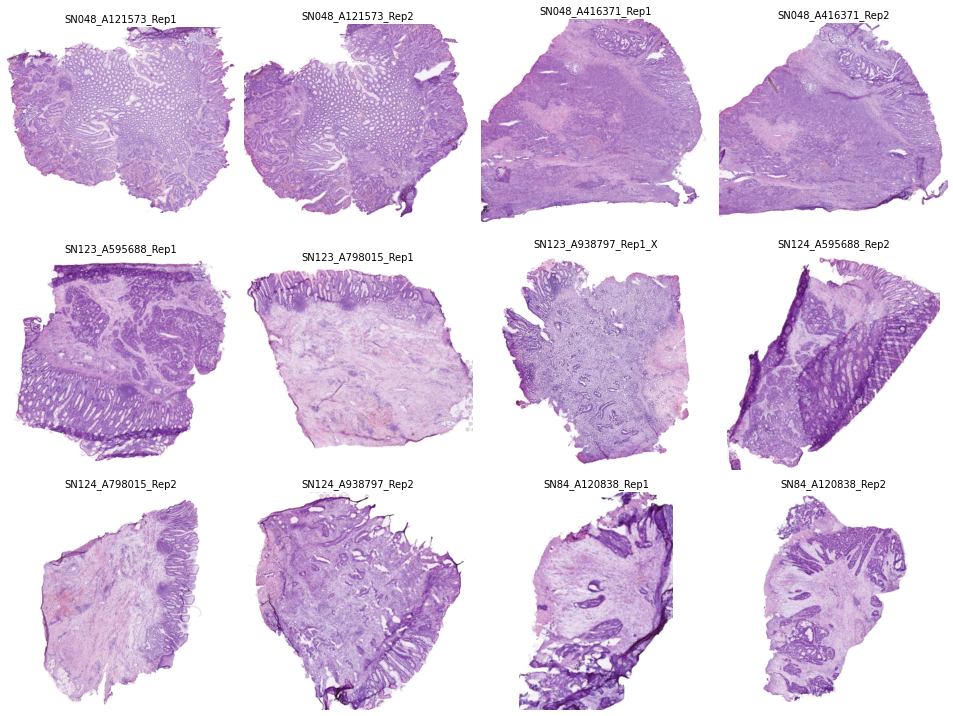

In [3]:
ch_samples = glob(data_dir + '/ch_*.h5ad')

# read AnnData objects into a list
adatas = [sc.read_h5ad(ad) for ad in ch_samples]
# get the sample names stored from the 'sample_id' column
sample_names = [ad.obs["sample_id"][0] for ad in adatas]

# look at the H&Es
plt.rcParams['figure.dpi'] = 60
fig, ax = plt.subplots(3, 4, figsize=(4 * 4, 3 * 4))
ax = ax.flatten()
for a in ax:
    a.axis('off')
for idx, ad in enumerate(adatas):
    sc.pl.spatial(ad, color=None, size=1.5, alpha=0,
                  ax=ax[idx], show=False, cmap='viridis')
    ax[idx].set_title(f'{ad.obs["sample_id"][0]}')
plt.tight_layout()
plt.show()

Next, we can use `ch.plot_svg_matrix` to visualize the SVG overlap matrix. By examining the pairwise overlaps between spatially variable genes across samples, we can gain insights into the expected variability in tissue compartments. This analysis also enables the identification of significant overlaps, particularly between biological replicates.

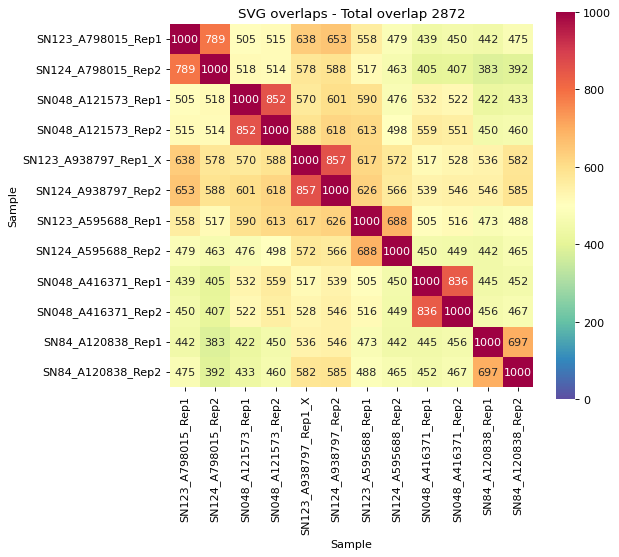

In [4]:
# plot spatially variable gene overlaps
plt.rcParams['figure.dpi'] = 80
ch.plot_svg_matrix(adatas, figsize=(8, 7), obs_name='sample_id', cluster=True)
plt.show()

To initiate the integration process, simply invoke `ch.integrate_adatas` on the list of AnnData objects. This function concatenates the samples into a single AnnData instance, creating an outer-joined SVG list.

In [5]:
# concatenate AnnData objects
adata = ch.integrate_adatas(adatas, sample_col='ch_sample_id')

print(adata)

AnnData object with n_obs × n_vars = 18146 × 12438
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'ch_sample_id'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', "Moran's I", 'spatially_variable'
    uns: 'spatial'
    obsm: 'spatial'
    varm: 'spatially_variable', "Moran's I"


We perform PCA here without integration and save the results to `'chr_X_pca_uncorrected'` in `.obsm` in order to compare the results later.

In [6]:
# replace ENSEMBL IDs with the gene symbols and make them unique
adata.var_names = list(adata.var['gene_symbols'])
adata.var_names_make_unique()

# run PCA
ch.pca(adata, n_pcs=50)
# save uncorrected PCs to compare the results later
adata.obsm['chr_X_pca_uncorrected'] = adata.obsm['chr_X_pca'].copy()

### 1.3 Integration with Harmony

We will use `ch.harmony_integration` to run `harmonypy` on the PCA embeddings. This will overwrite `adata.obsm['chr_X_pca']` unless specified otherwise.

2024-01-06 20:42:14,322 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-01-06 20:42:33,996 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-06 20:42:34,141 - harmonypy - INFO - Iteration 1 of 10
2024-01-06 20:42:40,160 - harmonypy - INFO - Iteration 2 of 10
2024-01-06 20:42:43,832 - harmonypy - INFO - Iteration 3 of 10
2024-01-06 20:42:47,979 - harmonypy - INFO - Converged after 3 iterations


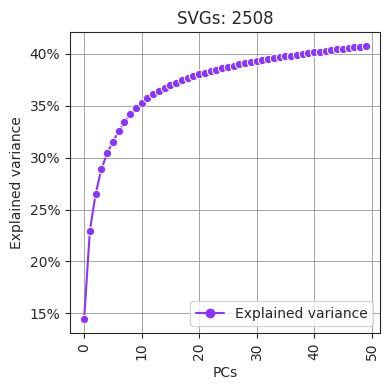

In [7]:
# perform harmony integration
ch.harmony_integration(adata, 'ch_sample_id', random_state=42, block_size=0.05)

# set 'sample_id' as categorical variable for plotting
# adata.obs['ch_sample_id'] = adata.obs['ch_sample_id'].astype('category')

plt.rcParams['figure.dpi'] = 100
ch.plot_explained_variance(adata)
plt.show()

### 4. Integration with Scanorama 

To run scanorama, we can utilize the `correct_scanpy` function. This function operates on a list of AnnData objects and produces a list containing the corrected expression matrices, so we perform this step prior to running `ch.integrate_adatas`. Lastly, we copy the PCA embedding to the main AnnData object (`adata`).

In [8]:
# dropping the 'ch_sample_id' as it was already added by running 'ch.integrate_adatas' in the previous cell.
for ad in adatas:
    ad.obs.drop(columns=['ch_sample_id'], inplace=True)

scr_adata = scanorama.correct_scanpy(adatas, return_dimred=True)
scr_adata = ch.integrate_adatas(scr_adata, sample_col='ch_sample_id')

# replace ENSEMBL IDs with the gene symbols and make them unique
scr_adata.var_names = list(scr_adata.var['gene_symbols'])
scr_adata.var_names_make_unique()

# run PCA
ch.pca(scr_adata, n_pcs=50)
# save uncorrected PCs
adata.obsm['chr_X_pca_scanorama'] = scr_adata.obsm['chr_X_pca'].copy()

Found 12438 genes among all datasets
[[0.00000000e+00 8.73689010e-01 0.00000000e+00 0.00000000e+00
  8.44594595e-03 4.88102502e-03 9.25925926e-03 0.00000000e+00
  7.58533502e-03 1.45918833e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.16590284e-04 0.00000000e+00
  2.21283784e-01 1.95241001e-02 3.76639865e-02 0.00000000e+00
  3.79266751e-03 3.62017804e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.09504838e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.10586227e-02 1.22025625e-03 1.70745589e-03 0.00000000e+00
  6.32111252e-04 5.93471810e-04 7.31707317e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00061013e-01 1.05574324e-01 8.71391076e-01
  2.78128951e-02 3.04054054e-02 5.18292683e-02 2.95275591e-03]
 [0.00000000e+00 0.00000000e

In [17]:
# let's define a function to create a single plot showing the tissue compartments for all samples

def plot_samples(adata, rows, cols, title=None):
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    ax = ax.flatten()
    for a in ax:
        a.axis('off')
    for idx, i in enumerate(adata.obs['ch_sample_id'].cat.categories):
        ch.plot(adata, dim=10, sample_id=i, ax=ax[idx], rasterized=True, seed=42,
                sample_col='ch_sample_id')
        obs_df = adata.obs[adata.obs['ch_sample_id'] == i]
        ax[idx].set_title(f'{obs_df["sample_id"][0]}')
    if title is not None:
        plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()


In [10]:
# uncorrected
ch.aa(adata, n_pcs=20, n_archetypes=10, pca_key='chr_X_pca_uncorrected')

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Uncorrected', sample_col='ch_sample_id', show_title=True, spot_size=20)

TypeError: plot_samples() missing 1 required positional argument: 'dim'

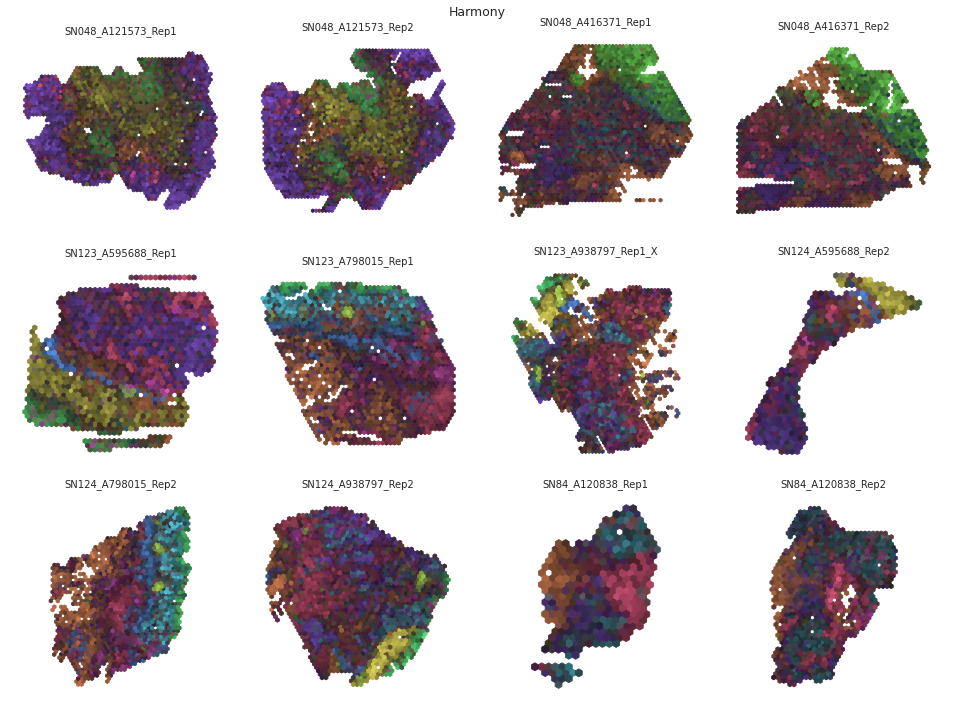

In [9]:
# harmony integration
ch.aa(adata, n_pcs=20, n_archetypes=10)

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Harmony', sample_col='ch_sample_id', show_title=True)

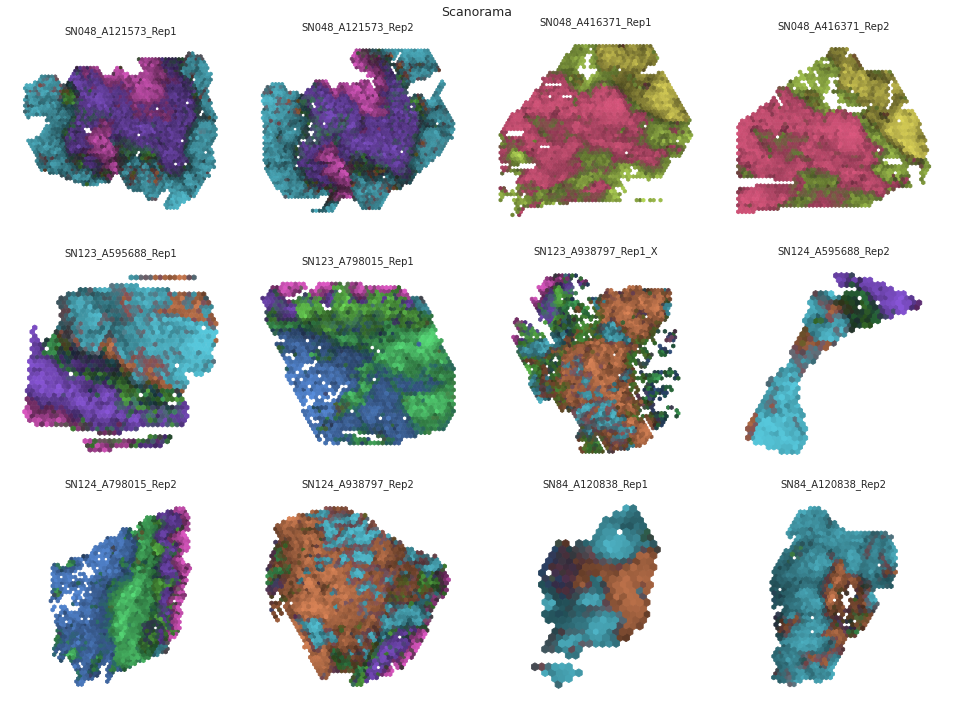

In [10]:
# scanorama integration
ch.aa(adata, n_pcs=20, n_archetypes=10, pca_key='chr_X_pca_scanorama')

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Scanorama', sample_col='ch_sample_id', show_title=True)

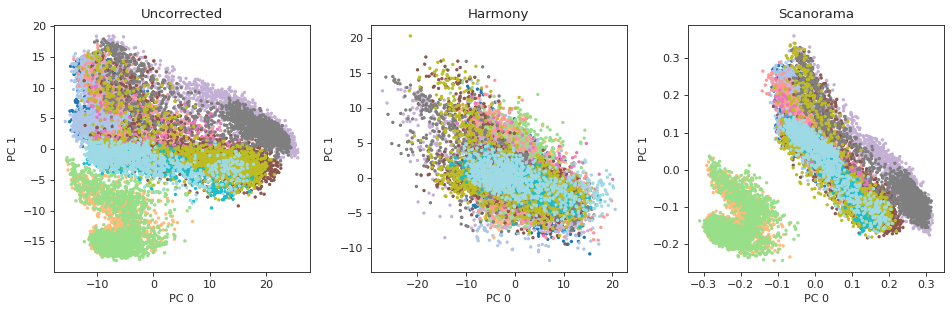

In [26]:
plt.rcParams['figure.dpi'] = 80

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(x=adata.obsm['chr_X_pca_uncorrected'][:, 0], y=adata.obsm['chr_X_pca_uncorrected'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab20')
axs[0].set_title('Uncorrected')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')

axs[1].scatter(x=adata.obsm['chr_X_pca'][:, 0], y=adata.obsm['chr_X_pca'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab20')
axs[1].set_title('Harmony')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 1')

axs[2].scatter(x=adata.obsm['chr_X_pca_scanorama'][:, 0], y=adata.obsm['chr_X_pca_scanorama'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab20')
axs[2].set_title('Scanorama')
axs[2].set_xlabel('PC 0')
axs[2].set_ylabel('PC 1')

plt.tight_layout()
plt.show()


## II. Renal Ischemia

In this section we integrate the mouse renal ischemia dataset. Input files can be downloaded from [here](https://drive.google.com/file/d/19AJMmKS0ONXRJvRCNryL5OxIluzOu7Tk/view?usp=drive_link).

In [3]:
data_dir = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/renal_ischemia'

In [23]:
samples = glob(data_dir + '/*.h5ad')

for sample in samples:

    ad = sc.read_h5ad(sample)

    # replace .uns dictionary key with the `sample_id` column to make it easier reach the H&E images
    spatial_key = list(ad.uns['spatial'].keys())[0]
    ad.uns['spatial'][ad.obs['sample_id'][0]] = ad.uns['spatial'][spatial_key]
    del ad.uns['spatial'][spatial_key]

    # we can optionally use ENSEMBL gene IDs instead of gene symbols to deal with non-unique gene identifiers
    # this circumvents issues during integration
    ad.var['gene_symbols'] = ad.var_names
    ad.var_names = ad.var['gene_ids']

    assert len(np.unique(ad.var_names)) == len(ad.var)

    # ad.var_names_make_unique()

    # filter low quality spots
    sc.pp.calculate_qc_metrics(ad, inplace=True)
    sc.pp.filter_genes(ad, min_cells=10)
    sc.pp.filter_cells(ad, min_counts=2000)
    sc.pp.filter_cells(ad, min_genes=500)

    # normalize counts
    sc.pp.normalize_total(ad, inplace=True, target_sum=1e4, exclude_highly_expressed=True)
    sc.pp.log1p(ad)

    # detect spatially variable genes
    ch.detect_svgs(ad, min_morans=0.05, min_spots=0.05)

    # save samples
    ad.write_h5ad(data_dir + f'/ch_{ad.obs["sample_id"][0]}.h5ad')

Calculating SVGs: 100%|██████████| 9958/9958 [00:49<00:00, 202.09it/s]


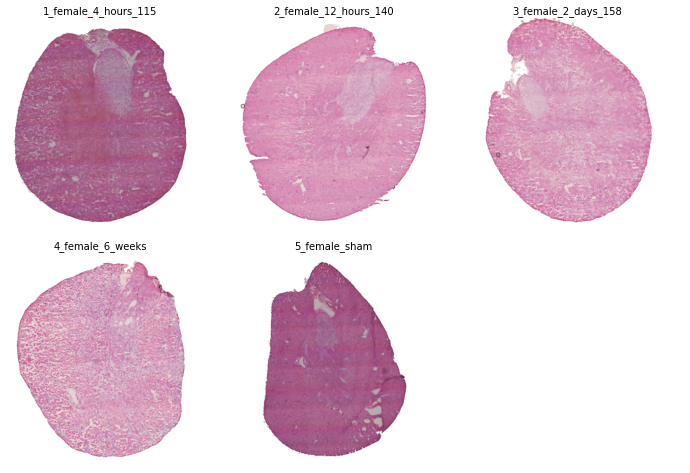

In [4]:
ch_samples = glob(data_dir + '/ch_*.h5ad')

# read AnnData objects into a list
adatas = [sc.read_h5ad(ad) for ad in ch_samples]
# get the sample names stored from the 'sample_id' column
sample_names = [ad.obs["sample_id"][0] for ad in adatas]

# look at the H&Es
plt.rcParams['figure.dpi'] = 60
fig, ax = plt.subplots(2, 3, figsize=(3 * 4, 2 * 4))
ax = ax.flatten()
for a in ax:
    a.axis('off')
for idx, ad in enumerate(adatas):
    sc.pl.spatial(ad, color=None, size=1.5, alpha=0,
                  ax=ax[idx], show=False, cmap='viridis')
    ax[idx].set_title(f'{ad.obs["sample_id"][0]}')
plt.tight_layout()
plt.show()

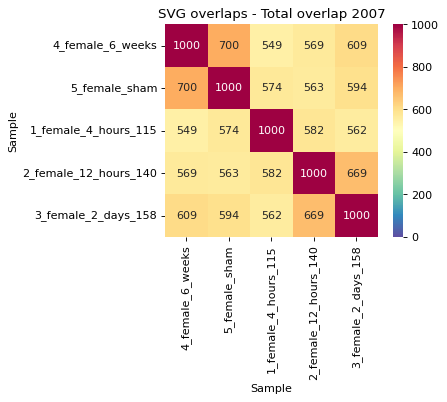

In [5]:
# plot spatially variable gene overlaps
plt.rcParams['figure.dpi'] = 80
ch.plot_svg_matrix(adatas, figsize=(8, 7), obs_name='sample_id', cluster=True)
plt.show()

In [ ]:
# concatenate AnnData objects
adata = ch.integrate_adatas(adatas, sample_col='ch_sample_id')

print(adata)

In [ ]:
# replace ENSEMBL IDs with the gene symbols and make them unique
adata.var_names = list(adata.var['gene_symbols'])
adata.var_names_make_unique()

# run PCA
ch.pca(adata, n_pcs=50)
# save uncorrected PCs to compare the results later
adata.obsm['chr_X_pca_uncorrected'] = adata.obsm['chr_X_pca'].copy()

In [ ]:
# perform harmony integration
ch.harmony_integration(adata, 'ch_sample_id', random_state=42, block_size=0.05)

# set 'sample_id' as categorical variable for plotting
# adata.obs['ch_sample_id'] = adata.obs['ch_sample_id'].astype('category')

plt.rcParams['figure.dpi'] = 100
ch.plot_explained_variance(adata)
plt.show()

In [ ]:
# dropping the 'ch_sample_id' as it was already added by running 'ch.integrate_adatas' in the previous cell.
for ad in adatas:
    ad.obs.drop(columns=['ch_sample_id'], inplace=True)

scr_adata = scanorama.correct_scanpy(adatas, return_dimred=True)
scr_adata = ch.integrate_adatas(scr_adata, sample_col='ch_sample_id')

# replace ENSEMBL IDs with the gene symbols and make them unique
scr_adata.var_names = list(scr_adata.var['gene_symbols'])
scr_adata.var_names_make_unique()

# run PCA
ch.pca(scr_adata, n_pcs=50)
# save uncorrected PCs
adata.obsm['chr_X_pca_scanorama'] = scr_adata.obsm['chr_X_pca'].copy()

In [ ]:
# uncorrected
ch.aa(adata, n_pcs=20, n_archetypes=10, pca_key='chr_X_pca_uncorrected')

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Uncorrected', sample_col='ch_sample_id', show_title=True, spot_size=20)

In [ ]:
# harmony integration
ch.aa(adata, n_pcs=20, n_archetypes=10)

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Harmony', sample_col='ch_sample_id', show_title=True)

In [ ]:
# scanorama integration
ch.aa(adata, n_pcs=20, n_archetypes=10, pca_key='chr_X_pca_scanorama')

plt.rcParams['figure.dpi'] = 60
ch.plot_samples(adata, rows=3, cols=4, dim=10, suptitle='Scanorama', sample_col='ch_sample_id', show_title=True)

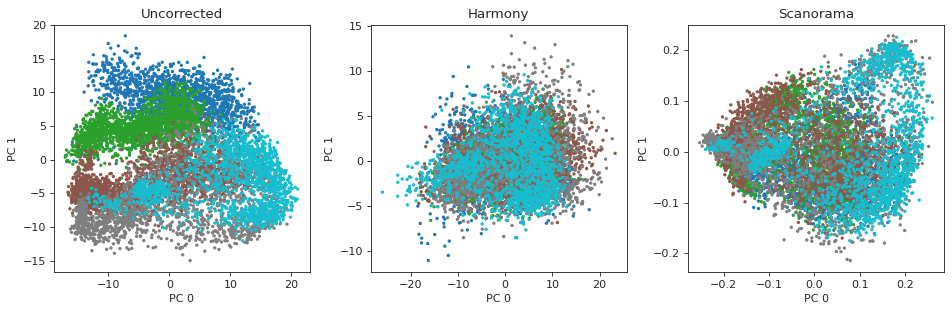

In [16]:
plt.rcParams['figure.dpi'] = 80

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(x=adata.obsm['chr_X_pca_uncorrected'][:, 0], y=adata.obsm['chr_X_pca_uncorrected'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab10')
axs[0].set_title('Uncorrected')
axs[0].set_xlabel('PC 0')
axs[0].set_ylabel('PC 1')

axs[1].scatter(x=adata.obsm['chr_X_pca'][:, 0], y=adata.obsm['chr_X_pca'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab10')
axs[1].set_title('Harmony')
axs[1].set_xlabel('PC 0')
axs[1].set_ylabel('PC 1')

axs[2].scatter(x=adata.obsm['chr_X_pca_scanorama'][:, 0], y=adata.obsm['chr_X_pca_scanorama'][:, 1],
            rasterized=True, s=4, c=adata.obs['ch_sample_id'].cat.codes, cmap='tab10')
axs[2].set_title('Scanorama')
axs[2].set_xlabel('PC 0')
axs[2].set_ylabel('PC 1')

plt.tight_layout()
plt.show()